# 2.2 Разведывательный анализ данных (EDA) - распределение признаков, статистические тесты. нормализация признакво

In [22]:
import pandas as pd
import numpy as np
import re
import unicodedata
from difflib import get_close_matches
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer
import scipy.stats as stats

In [2]:
df_clean = pd.read_csv('data/rosstat_data_clean.csv',index_col=0)
df_clean

,pcci_mean,fwp_mean,rpay_cum,cmr_mean,cmu_mean,alco_mean,grp_mean,hc_proc_ИС,hi_proc_НУЖУ,mad_mean,nm_mean,ppr_mean,ps_mean_proc_child,ps_mean_proc_pension,ps_mean_proc_work,rp_mean,rtpc_mean,wes_mean,pop_2023,dta_proc
region,,,,,,,,,,,,,,,,,,,,
алтайский_край,22805.0,25499.6,109.2,59.0,73.0,100.34,253174.02,16.7,14.9,108969.16,18163.200,17.56,38.0,6.0,56.0,3.157819e+08,156351.4,27.82,2130950,85.263286
амурская_область,31385.8,42636.8,111.4,16.2,26.8,98.18,451290.98,22.7,14.7,81975.30,6964.000,16.04,38.0,6.0,56.0,1.259368e+08,233941.4,24.74,756198,91.157871
архангельская_область,34001.4,48074.4,110.9,14.4,37.0,77.60,699021.38,16.7,13.4,102607.24,8692.598,13.88,35.0,7.0,58.0,5.432534e+08,242743.6,21.82,1005687,90.141764
астраханская_область,23913.0,33140.0,113.5,15.6,49.8,36.08,497990.36,22.5,16.4,67869.84,9637.798,15.56,40.0,5.0,55.0,6.728494e+08,176863.0,26.36,950557,48.771720
белгородская_область,31222.4,32013.2,114.3,25.0,33.0,48.02,578765.06,13.7,12.0,75843.20,11303.796,7.68,22.0,6.0,22.0,1.580985e+09,229457.6,14.74,1514527,142.290431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
чеченская_республика,23454.8,25976.0,96.1,112.0,93.4,6.25,157075.56,19.6,19.1,58809.82,26152.780,19.92,46.0,7.0,47.0,6.466829e+07,122433.6,28.48,1533209,112.870783
чувашская_республика,19075.4,27197.8,112.2,12.4,26.4,98.56,258840.44,28.0,27.2,99111.56,10218.794,17.84,33.0,6.0,61.0,4.173893e+08,136751.4,23.52,1173177,70.321102
чукотский_автономный_округ,78492.6,101050.8,116.9,4.2,3.2,331.68,1780297.36,20.9,14.0,118130.44,483.000,8.48,24.0,1.0,25.0,9.416384e+07,205954.2,6.48,47840,35.953177


In [3]:
# Обновлённый словарь с учётом новых признаков

data_prefix = {
    'pcci_mean' : 'Среднедушевые денежные доходы (среднегодовой за последние 5 лет)',
    'rpay_cum' : 'Накопительный индекс реальной начисленной зароботной палты (за последние 5 лет % к пред. году)',
    'fwp_mean' : 'Среднемесячная номинальная начисленная заработная плата (сренегодовое за последние 5 лет)',
    'cmr_mean' : 'Среднегодовое число умерших на первом году жизни детей в сельской местности',
    'cmu_mean' : 'Среднегодовое число умерших на первом году жизни детей в городской местности',
    'dta_proc' : 'Среднегодовое число людей с инвалидностью до 60 лет',
    'alco_mean' : 'Среднегодовая заболеваемость с впервые в жизни установленным диагнозом алкоголизма и алкогольного психоза на 100 тыс. населения',
    'grp_mean' : 'Среднегодовой валовой региональный продукт на душу населения, в рублях.',
    'hc_proc_ИС' : 'Процент домохозяйств, испытывающих стесненные условия',
    'hi_proc_НУЖУ' : 'Процент домохозяцств, неудовлетварённых жилищными условиями',
    'mad_mean' : 'Среднегодовоя заболеваемость по всем группам населения на 100 тыс. чел',
    'nm_mean' : 'Среднегодовое количество новорожденных',
    'pop_2023' : 'Численность населения по регионам и федеральным округам за 2023 год',
    'ppr_mean' : 'Среднегодовой процент людей, живущих за чертой бедности (с денежными доходами ниже величины прожиточного минимума)',
    'ps_mean_proc_child' : 'Среднегодовое распределение малоимущего населения по социально-демографическим группам (дети) по регионам',
    'ps_mean_proc_work' : 'Среднегодовое распределение малоимущего населения по социально-демографическим группам (трудящиеся) по регионам',
    'ps_mean_proc_pension' : 'Среднегодовое распределение малоимущего населения по социально-демографическим группам (пенсионеры) по регионам',
    'rp_mean' : 'Общий среднегодовой объём отгруженных товаров собственного производства или работ/услуг, выполненных собственными силами',
    'rtpc_mean' : 'Среднегодовой оборот розничной торговли на душу населения, в рублях.',
    'wes_mean' : 'Среднегодовые расходы на социальную политику от общих расходов бюджета региона, % в год'
}

### 2.2.1. Проверим распределение признаков на boxplot диаграммах

In [4]:
def plot_boxplots_for_features(df: pd.DataFrame, data_prefix: dict, ncols: int = 3):
    cols = [c for c in data_prefix if c in df.columns]
    df_num = df[cols].apply(pd.to_numeric, errors="coerce")

    nrows = int(np.ceil(len(cols) / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows))
    axes = axes.flatten()

    colors = plt.cm.Set3.colors  # готовая палитра

    for i, col in enumerate(cols):
        bp = axes[i].boxplot(
            df_num[col].dropna(),
            patch_artist=True,
            showmeans=True
        )
        for patch in bp['boxes']:
            patch.set(facecolor=colors[i % len(colors)], alpha=0.7)
        axes[i].set_title(col, fontsize=10)
        axes[i].grid(axis="y", linestyle="--", linewidth=0.5)

    # убрать лишние пустые оси
    for j in range(len(cols), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

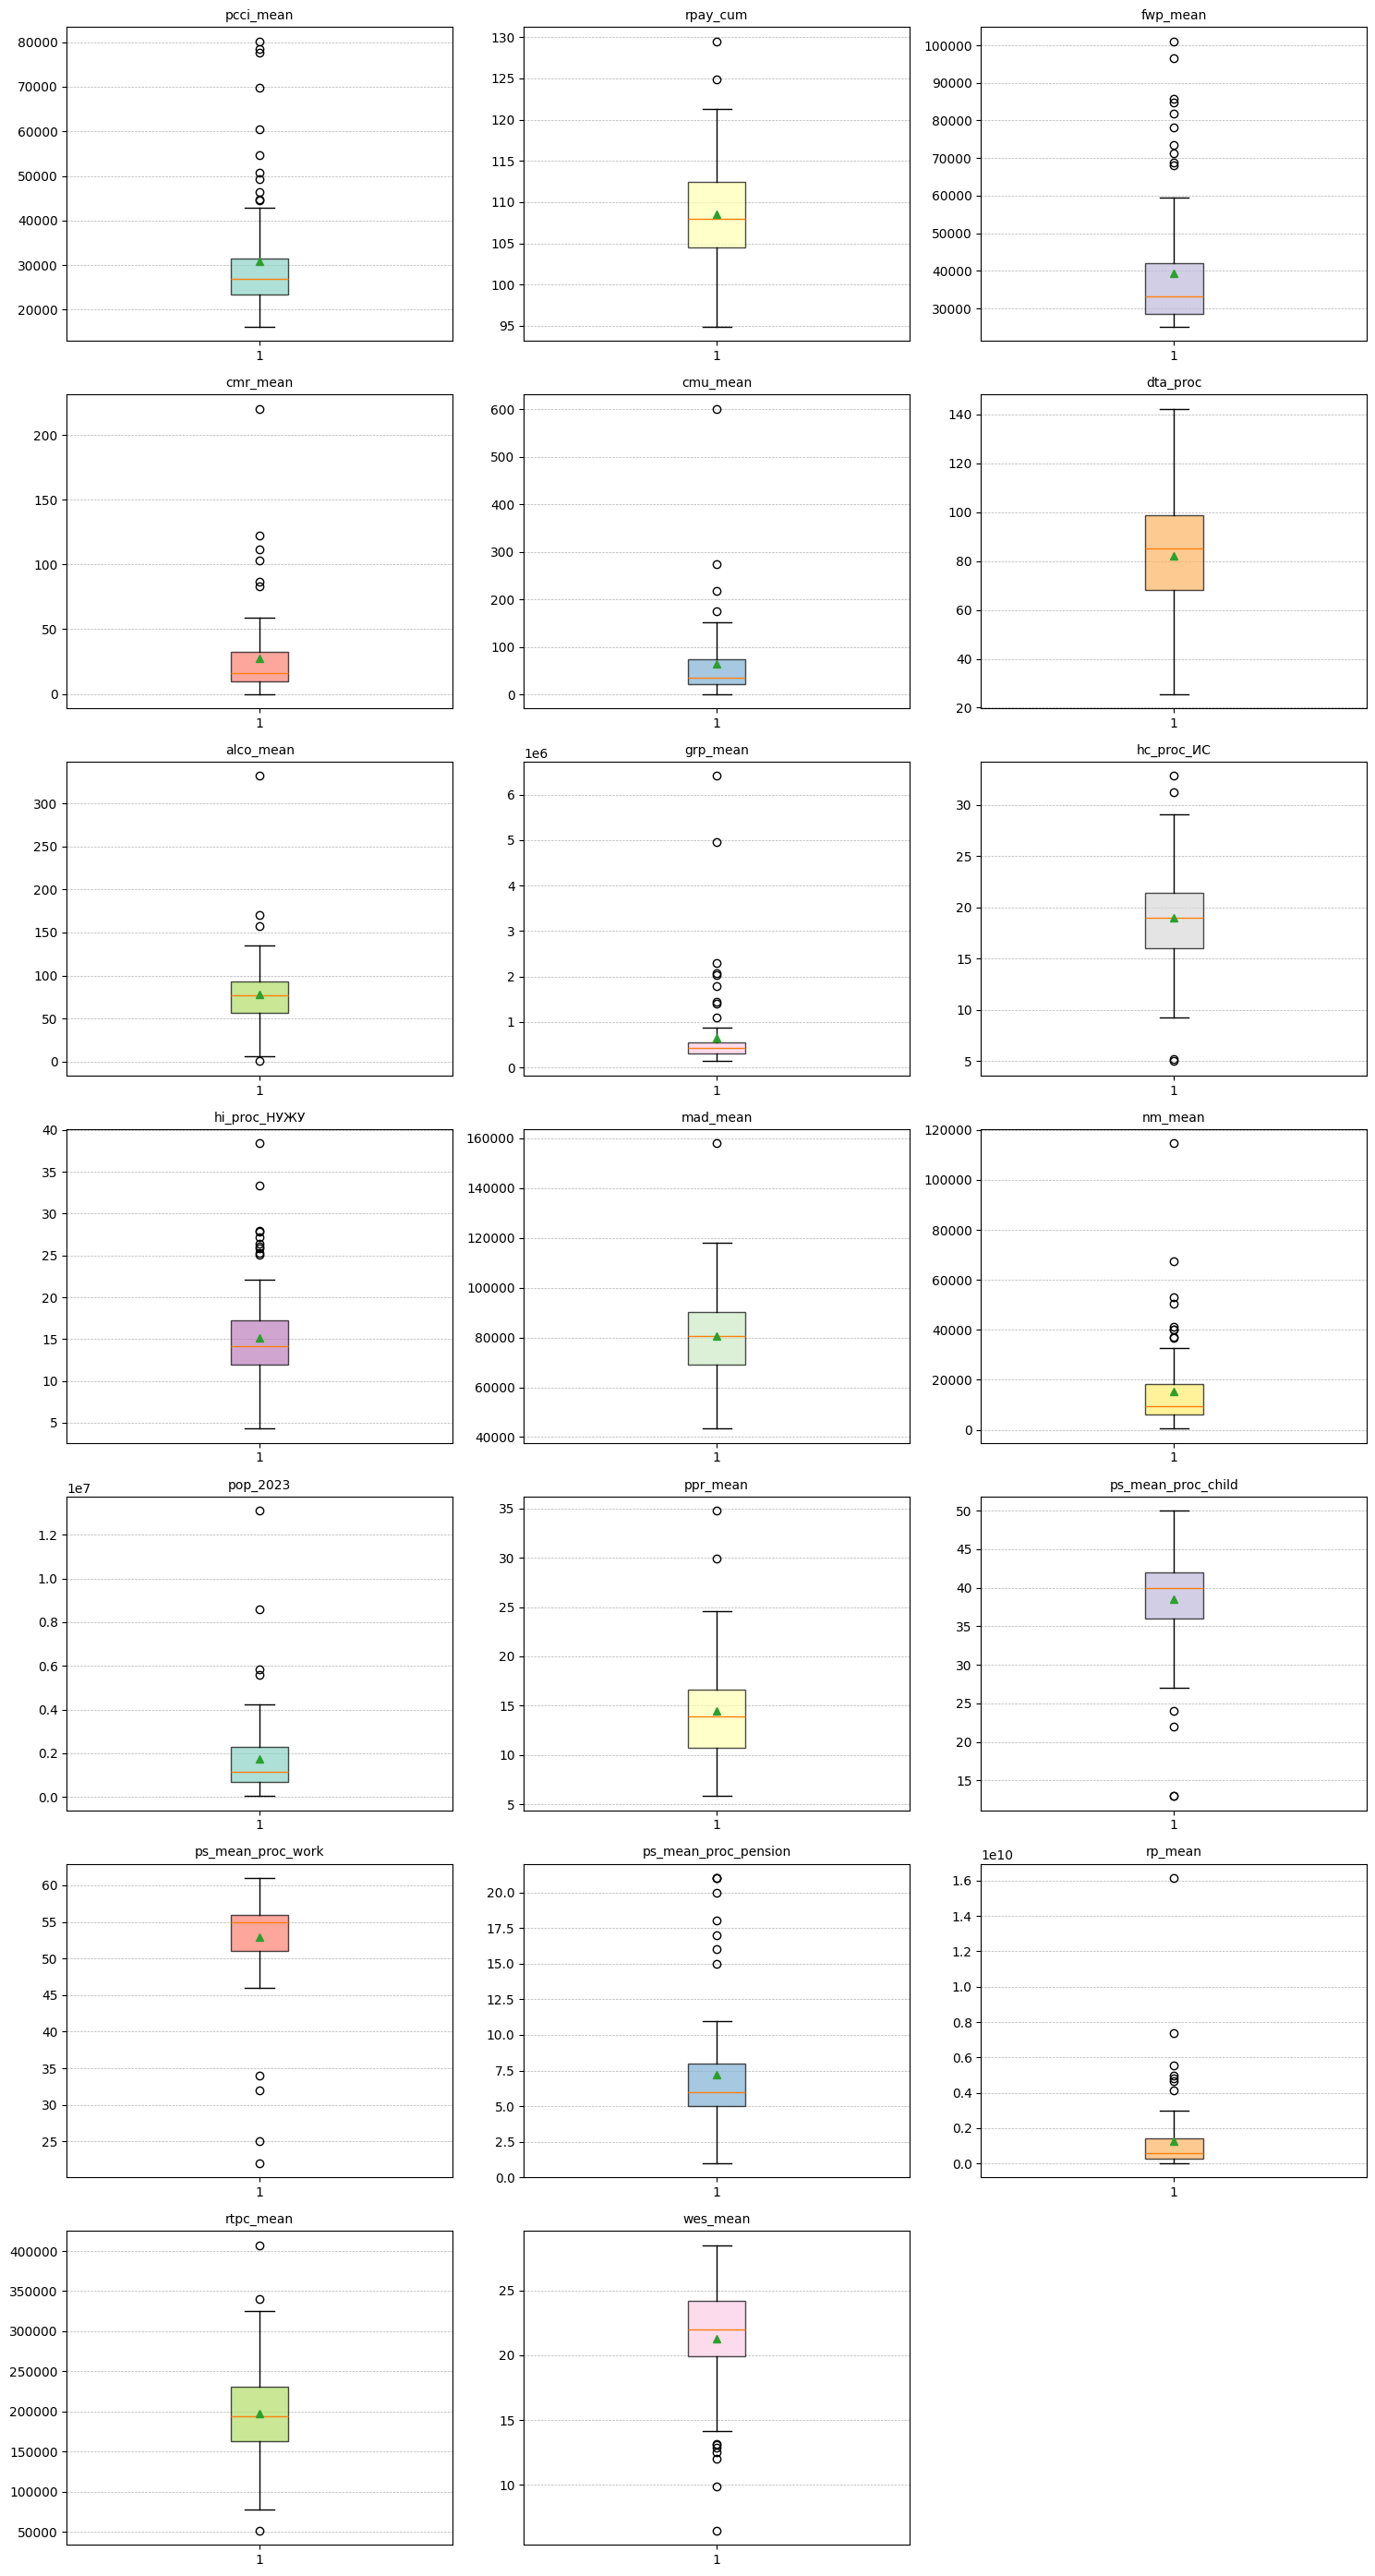

In [13]:
plot_boxplots_for_features(df_clean, data_prefix)

> В данных присутствуют выбросы. П некоторым регионом статистические показатели сильно различаются

### 2.2.2. Нормализация

> Првоерка нормальности расперделения признаков - тест Шапиро–Уилка

In [ ]:

def norm_test(df_clean):
    col_names = list(df_clean.columns)

    #Словарь с выводом о нормальности/не нормальности по каждому признаку

    # списки для признаков
    norm = []
    no_norm = []

    alpha = 0.05

    for col in col_names:
        stat, p = stats.shapiro(df_clean[col])
        
        if p <= alpha:
            no_norm.append(col)   # ненормальное распределение
        else:
            norm.append(col)      # нормальное распределение
    return norm, no_norm

# Вызов функции
norm, no_norm = norm_test(df_clean)
print(f'Распределение нормальное: {len(norm)} признаков\nРаспределение не нормальное: {len(no_norm)} признаков')

Распределение нормальное: 3 признаков
Распределение не нормальное: 17 признаков


> Нормальное распределение у 3х признаков из 20

- StandardScaler - используем для нормального распределения
- RobustScaler- используем для не нормального распределения

In [6]:
df_scal = df_clean.copy()

In [7]:

scaler = StandardScaler()
df_scal[norm] = scaler.fit_transform(df_clean[norm])

In [8]:
scaler = RobustScaler()
df_scal[no_norm] = scaler.fit_transform(df_clean[no_norm])

In [9]:
df_scal.to_csv('data/rosstat_data_scal.csv')

> Сформирован нормализованный датасте df_scal.

**Для анализа работы моделей кластеризации, сформируем второй датасет с нормализецией симметрии признаков**

### 2.2.3. Ассиметрия

In [14]:
def asym_test(df):
    col_names = list(df.columns)

    # списки для признаков
    sym = []       # симметричные
    asym = []      # с асимметрией

    alpha = 0.05

    for col in col_names:
        x = df[col]
        if len(x) < 8:  # тесты требуют минимум наблюдений
            continue

        # тест Д’Агостино–Пирсона (учитывает и асимметрию, и эксцесс)
        k2, p = stats.normaltest(x)

        if p <= alpha:
            asym.append(col)   # есть асимметрия/ненормальность
        else:
            sym.append(col)    # симметричное/нормальное распределение
            
    return sym, asym

sym, asym = asym_test(df_clean)
print(f'Распределение симментрично: {len(sym)} признаков\nРаспределение ассимметрично: {len(asym)} признаков')

Распределение симментрично: 3 признаков
Распределение ассимметрично: 17 признаков


In [18]:
x = set(sym) & set(norm)
print(x)

{'dta_proc', 'hc_proc_ИС', 'rpay_cum'}


> 17 из 20 признаков имеют перекосы, асиметрия и не нормальность расперделения совпадают по признакам

- выполним трансформацию данных Yeo–Johnson для несимметричных данных

In [15]:
df_scal_sym = df_clean.copy()

In [ ]:
# Нормализация асиметрии Yeo–Johnson
pt = PowerTransformer(method="yeo-johnson", standardize=True)
df_scal_sym[list(asym)] = pt.fit_transform(df_scal_sym[list(asym)])

In [20]:
scaler = StandardScaler()
df_scal_sym[list(norm)] = scaler.fit_transform(df_scal_sym[list(norm)])

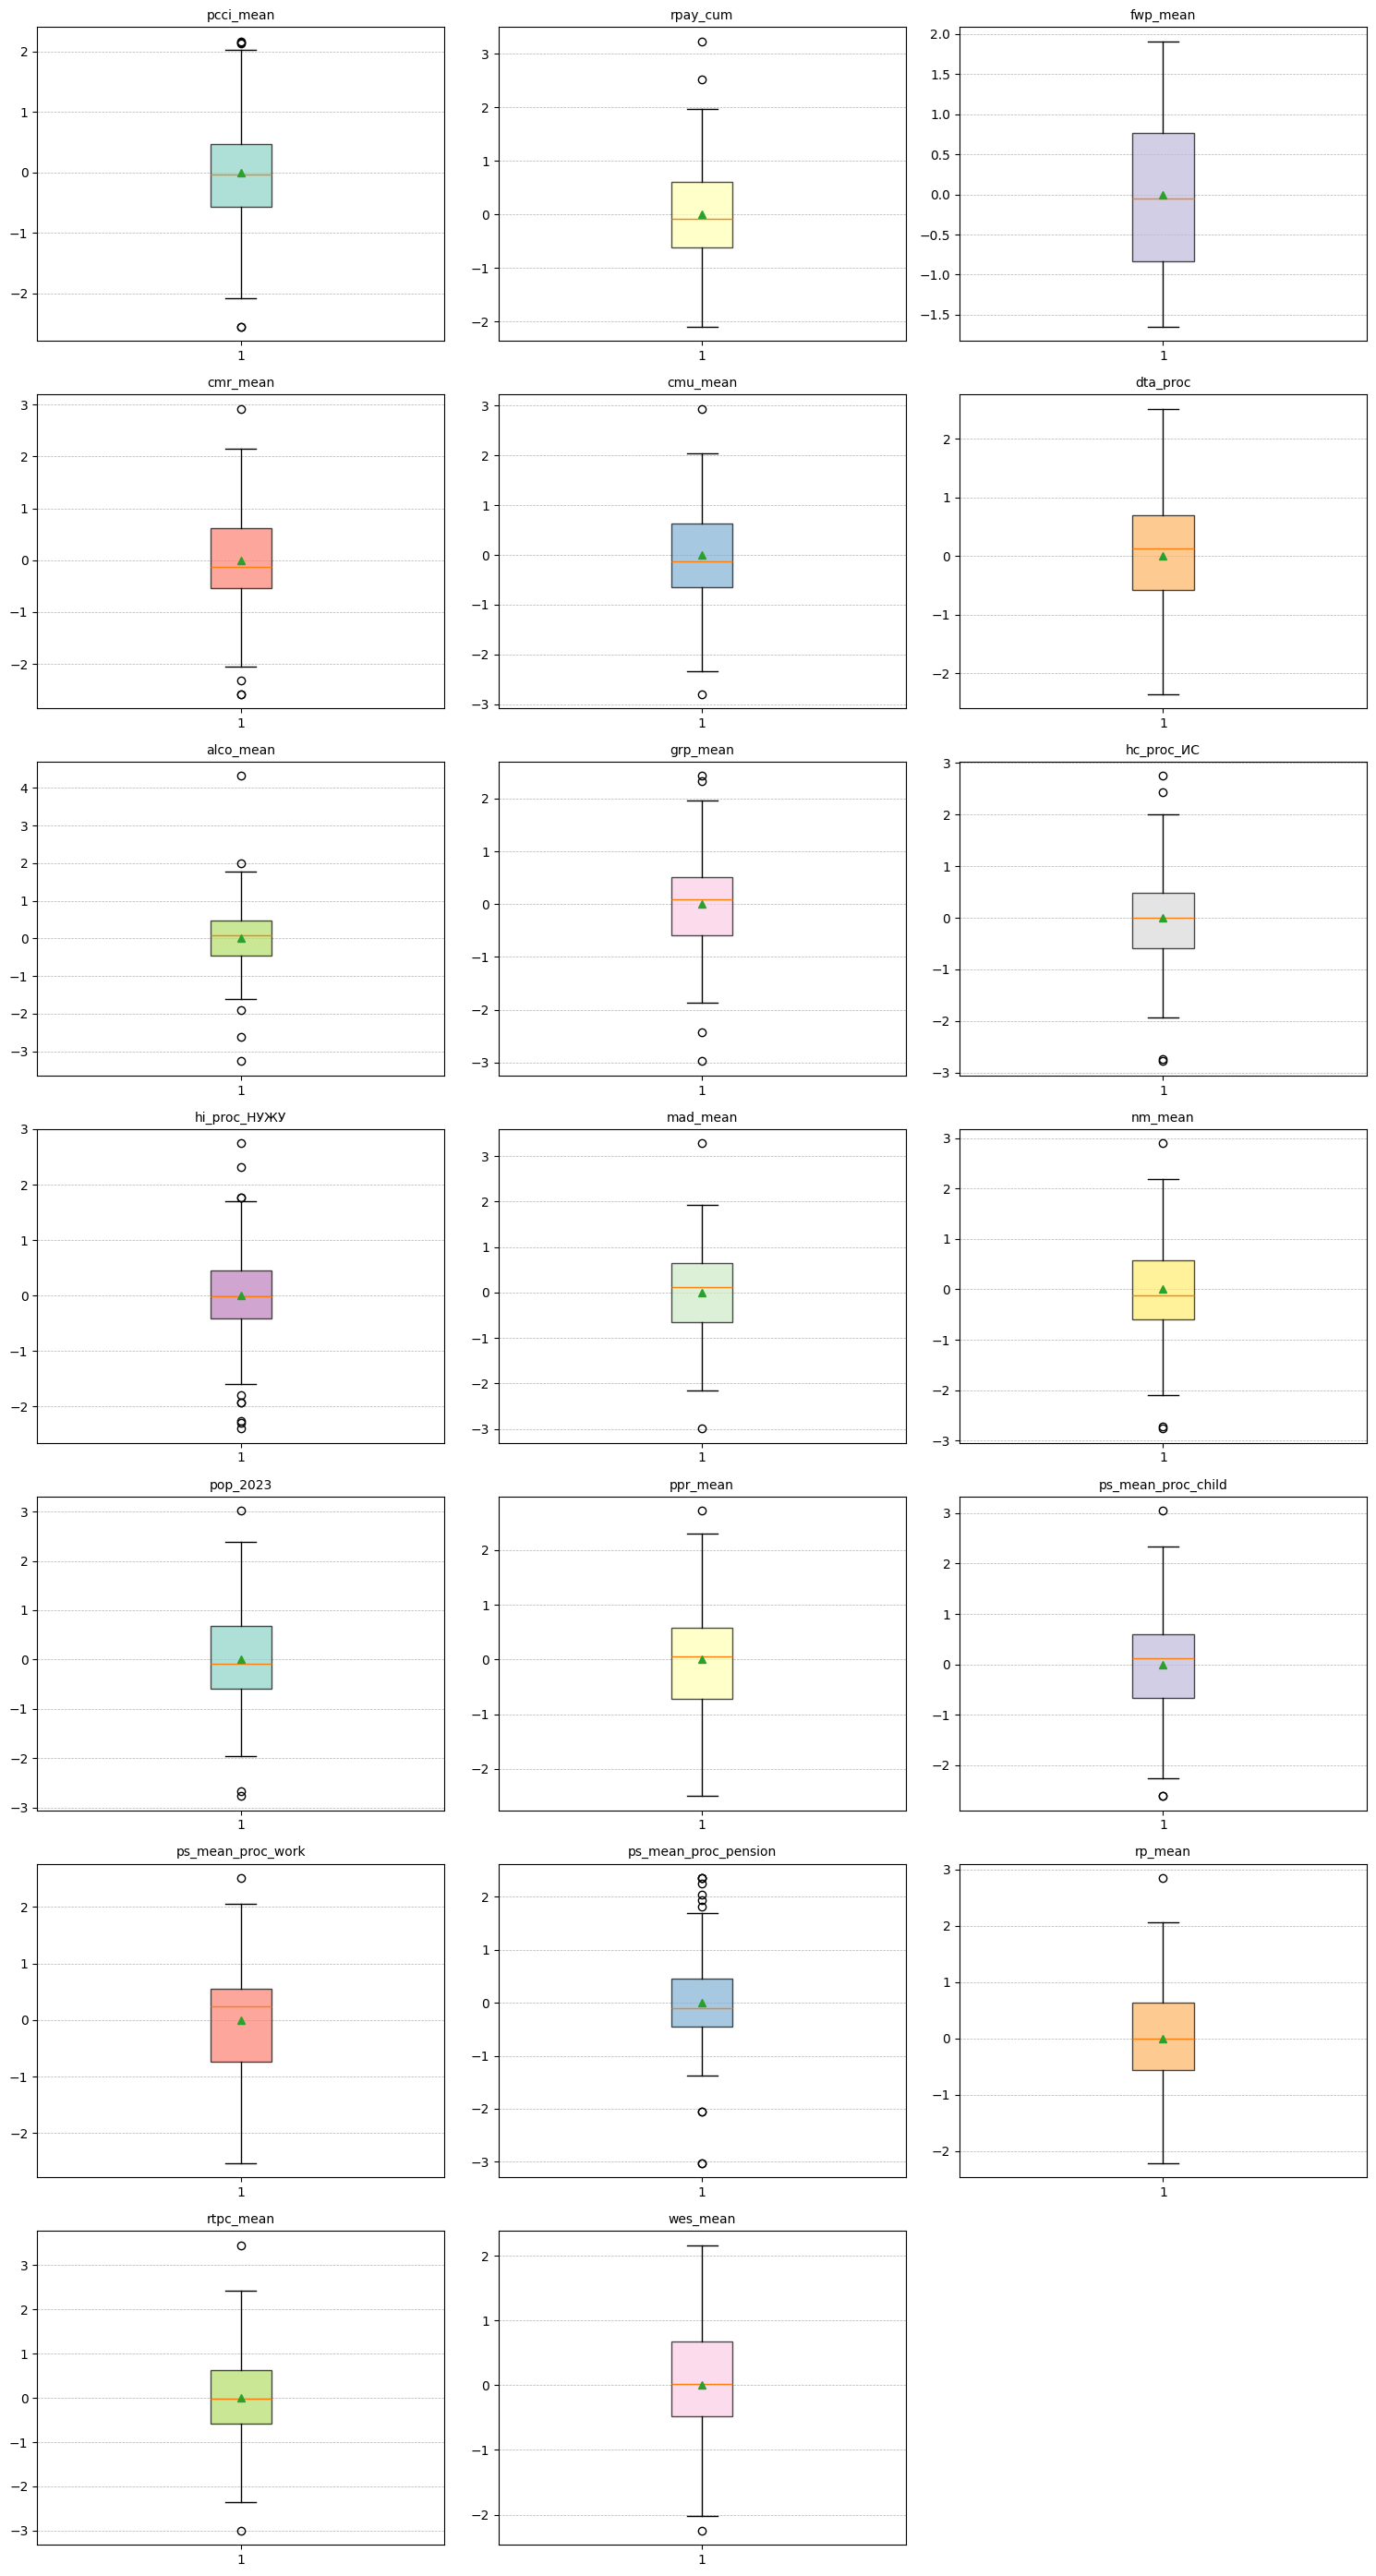

In [21]:
plot_boxplots_for_features(df_scal_sym, data_prefix)

In [114]:
df_scal_sym.to_csv('data/rosstat_data_scal_sym.csv')

# Выводы по разделу 2.2:

- Проанализировано распределение признаков
- Выполнена стандартизация/нормализация
- Устранена ассиметрия
- Подготвлено 2 варианты данных для построения модели кластеризации